In [115]:
import numpy as np
import pandas as pd 
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

# Black Scholes Pricing Model

In [117]:
def options(K, S, r, dT, sigma, opt_type):
    d1 = (np.log(S/K)+(r+sigma**2/2)*dT)/(sigma*np.sqrt(dT))
    d2 = d1 - sigma*np.sqrt(dT)
    if opt_type == 'Call':
        price = S*norm.cdf(d1)-K*np.exp(-r*dT)*norm.cdf(d2)
    elif opt_type == 'Put':
        price = K*np.exp(-r*dT)*norm.cdf(-d2)-S*norm.cdf(-d1)
    else: 
        print("Invalid type")
    return price 
        

# Determining Greeks

In [119]:
def greeks(K,S,r, T, sigma, opt_type):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    pdf_d1 = norm.pdf(d1)  #N'(d1)
    cdf_d1 = norm.cdf(d1) #N(d1)
    d2 = d1 - sigma*np.sqrt(T) 
    pdf_d2 = norm.pdf(d2)  #N'(d2)
    cdf_d2 = norm.cdf(d2)  #N(d2)

    # computing gamma 
    gamma = pdf_d1/(S*sigma*np.sqrt(T))

    #computing vega 
    vega = S*pdf_d1*np.sqrt(T)

    # if option is a call option 
    if opt_type == 'Call':
        delta = cdf_d1
        theta = -(S*pdf_d1*sigma)/(2*np.sqrt(T))-K*r*np.exp(-r*T)*cdf_d2
        rho = K*T*np.exp(-r*T)*cdf_d2

    # if option is a put option 
    elif opt_type == 'Put':
        delta = norm.cdf(-d1)
        theta = -(S*pdf_d1*sigma)/(2*np.sqrt(T))+K*r*np.exp(-r*T)*norm.cdf(-d2)
        rho = -K*T*np.exp(-r*T)*norm.cdf(-d2)


    return {
        'Delta': delta,
        'Gamma': gamma,
        'Theta (per day)': theta / 365,
        'Vega (per 1% vol)': vega / 100,
        'Rho (per 1% rate)': rho / 100
    }

# Varying S for call options

In [121]:
# varing stock prices, s 
S = np.linspace(1, 100, 1000)
greek_list = ('Delta','Gamma','Theta','Vega','Rho')

In [122]:
K = 20
r = 0.02
T = 2
sigma = 0.1
opt_type = 'Call'

def plot(K,S,r, T, sigma, opt_type):
    count = 1
    for greek in greek_list: 
        if greek == 'Theta': 
            greek = 'Theta (per day)'
        elif greek == 'Vega':
            greek ='Vega (per 1% vol)'
        elif greek == 'Rho':
            greek = 'Rho (per 1% rate)'
        res = []
        for s in S: 
            res.append(greeks(K,s,r, T, sigma, opt_type)[greek])
        plt.figure(figsize = (50,5))
        plt.subplot(2,3,count)
        plt.title(f'{greek} as Stock Prices Vary')
        plt.xlabel('Stock Price')
        plt.ylabel(f'{greek}')
        plt.plot(res)
        count+=1

## Plotting Deltas

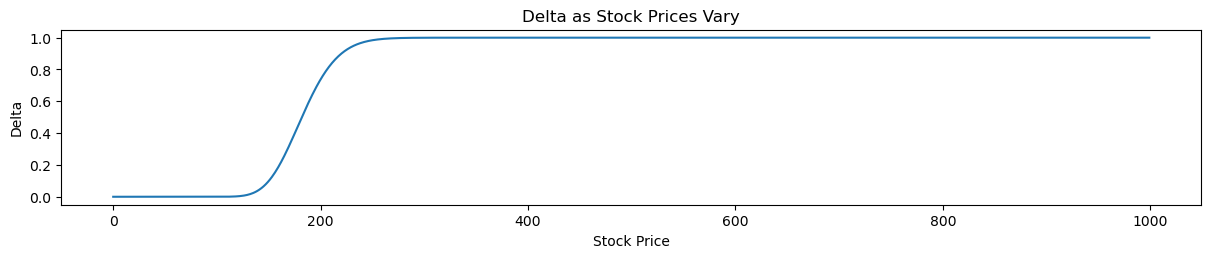

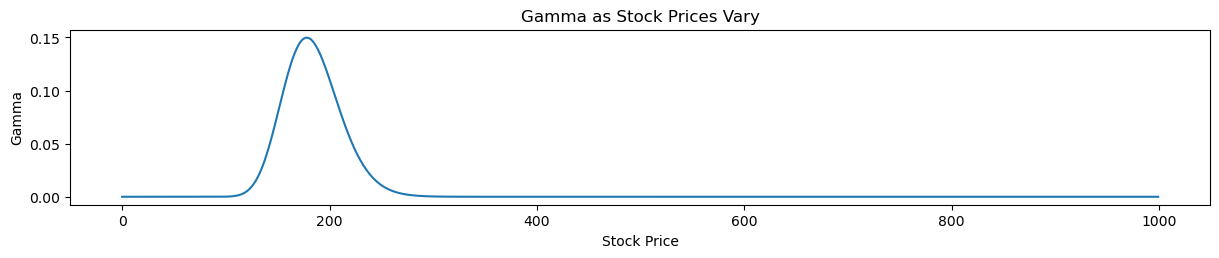

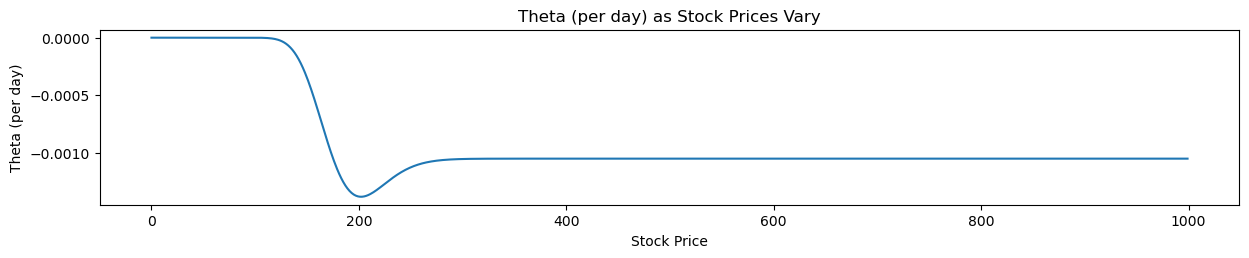

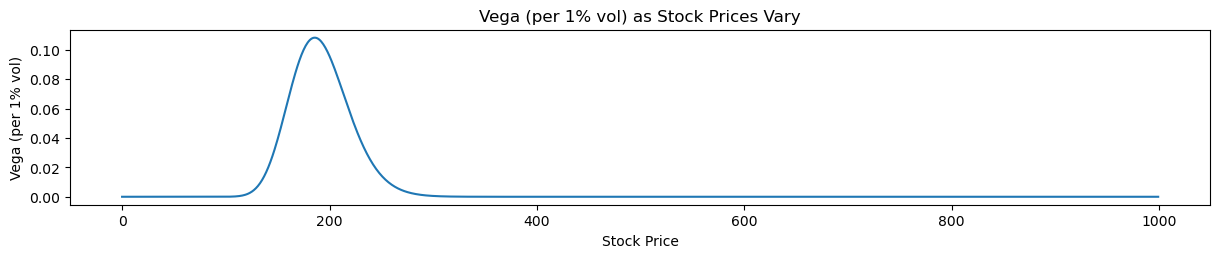

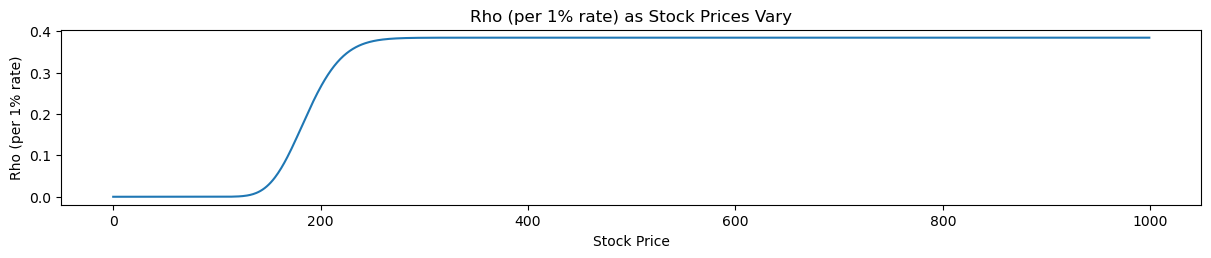

In [124]:
plot(K,S,r, T, sigma, opt_type)

# Put options

In [126]:
opt_type = 'Put'

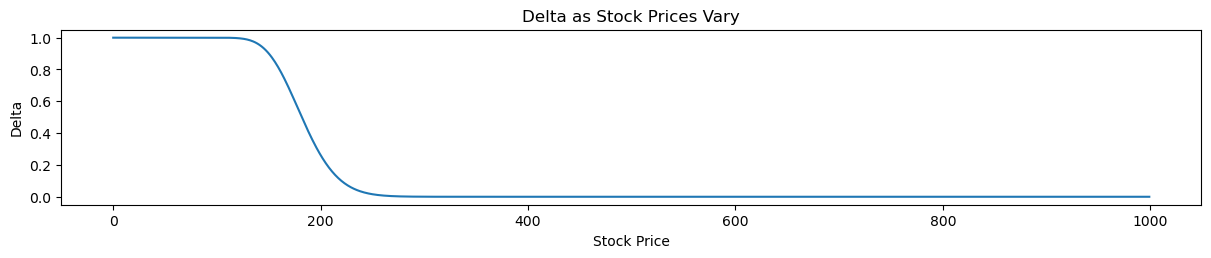

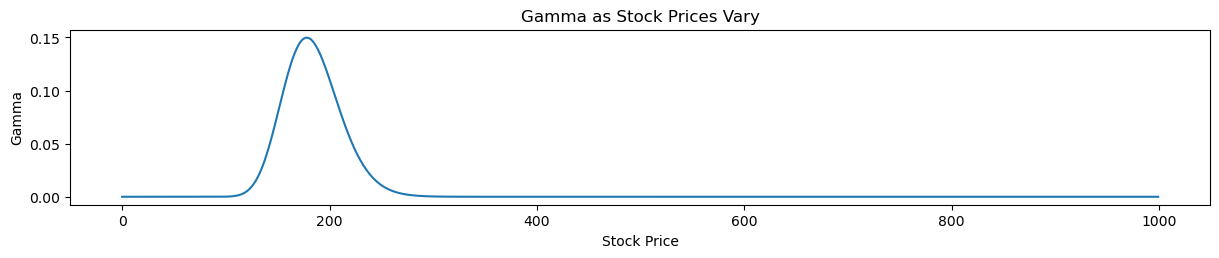

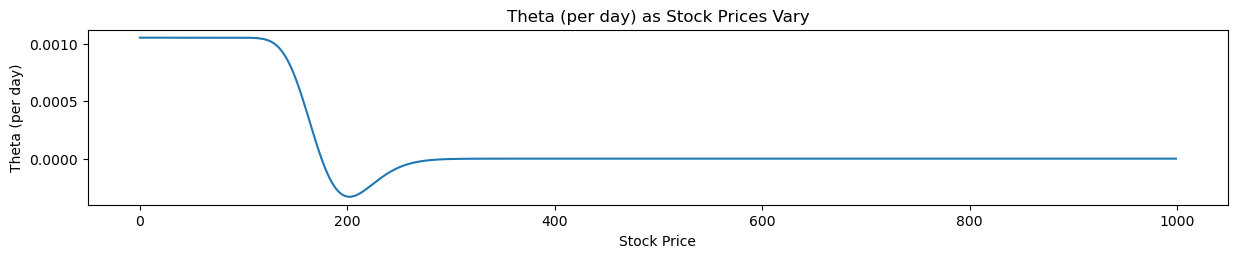

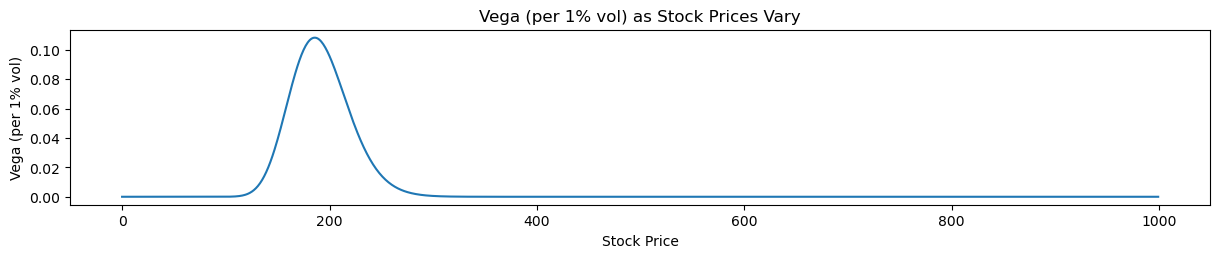

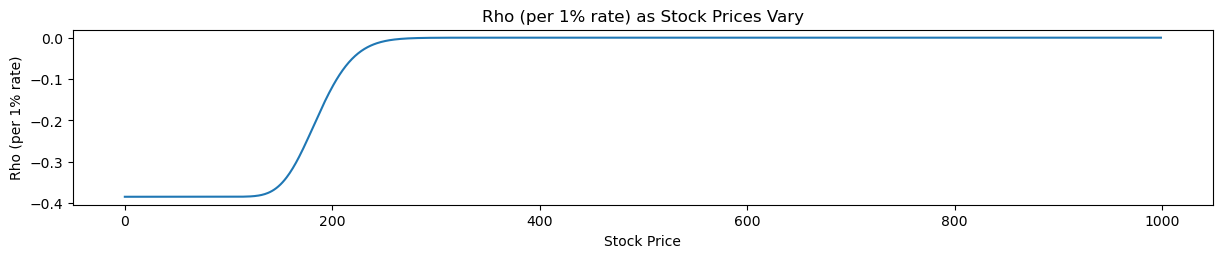

In [127]:
plot(K,S,r, T, sigma, opt_type)

## American Option Pricing using Binomial Tree

In [131]:
def flatten(l):
    new =[]
    for items in keys:
        for item in items:
            new.append(item)
    return new

In [133]:
# generates nodes at each time step, where n is the number of nodes
def generating_nodes(t, n_nodes, u, d, S): 
    r ={}
    for i in range(n_nodes):
        node = (t-i)*'u'+i*'d'
        if i ==0:
           s = S*(t-i)*u
        elif i ==t:
            s=S*i*d
        else:
            s = S*(t-i)*u*i*d
        r[node] = [s]
    return r

In [134]:
def early_exercise(St, K, opt_type):
    if opt_type == 'Call':
        return np.max([St-K,0]) 
    elif opt_type =='Put':
        return np.max([K - St,0]) 

In [135]:
def option_val(data, branch, dt, r,p): 
    upper = branch+'u'
    n_u = upper.count('u')
    n_d = upper.count('d')
    upper = n_u*'u'+n_d*'d'
    upper_branch = data[upper][1]
    lower = branch+'d'
    n_u = lower.count('u')
    n_d = lower.count('d')
    lower = n_u*'u'+n_d*'d'
    lower_branch = data[lower][1]
    val = np.exp(r*dt)*(p*upper_branch +(1-p)*lower_branch)
    return val 

In [216]:
def american_pricing(S, K, sigma, r, T, steps, opt_type):
    dt = T/steps
    data ={} # stores stock price, value of early exercise, value of option at each node 
    keys =[]
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt)-d)/(u-d)
    for t in range(1,steps+1):
        res = generating_nodes(t,t+1, u, d, S) # creating nodes and stock price at each node 
        data.update(res)
    for k in data: 
        St = data[k][0]
        data[k].append(early_exercise(St, K, opt_type))
    end_node = len(list(data.keys())[-1])
    for k in reversed(list(data.keys())): 
        if len(k) == end_node:
            next
        else:
            value = option_val(data, k, dt, r,p)
            if value> data[k][1]: # if option value at given node exceeds payoff from early exercise
                data[k][1] = value
            else: # if payoff from early exercise exceeds option value ie. early exercise
                print(f'At time {k}, exercised early')
    price = option_val(data, '',dt, r,p)
    return {'Price':price}

In [222]:
american_pricing(10, 15, 0.1, 0.02, 2, 2, 'Call')

{'Price': 3.031552305779975}